

# Checking the performance of different optimizers on MedMNIST dataset
### Special thanks to <a href="https://www.mayo.edu/research/labs/radiology-informatics/overview">Dr. Bradley J. Erickson M.D., Ph.D.</a> - Department of Radiology, Mayo Clinic
#### Acknowledgements: <a href="http://www.cancerimagingarchive.net/">The Cancer Imaging Archive (TCIA)</a>; <a href ="http://rsnachallenges.cloudapp.net/competitions/4">Radiological Society of North America</a>; <a href= "http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf">National Institute of Health</a>


In [60]:
!git clone "https://github.com/apolanco3225/Medical-MNIST-Classification"

Cloning into 'Medical-MNIST-Classification'...
remote: Enumerating objects: 58532, done.
remote: Total 58532 (delta 0), reused 0 (delta 0), pack-reused 58532
Receiving objects: 100% (58532/58532), 77.86 MiB | 32.39 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Checking out files: 100% (58959/58959), done.


In [61]:
cd Medical-MNIST-Classification/

/content/Medical-MNIST-Classification/Medical-MNIST-Classification


In [62]:
!ls

hints.txt  images  MedNIST.ipynb  resized


In [63]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)



## Loading Data and Creating Datasets
Due to cost, privacy restrictions, and the rarity of certain conditions, gathering medical datasets can be particularly challenging. Once gathered from disparate sources, these data will need to be standardized for training. Preparing data at this level is beyond the scope of this short introductory primer. We have gathered images from several sets at TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset and standardized them to the same size.

The code below examines our image set, organizes the filenames, and displays some statistics about them.


In [64]:
dataDir = 'resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 58954 images in 6 distinct categories
Label names: ['HeadCT', 'BreastMRI', 'ChestCT', 'AbdomenCT', 'CXR', 'Hand']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]
Image dimensions: 64 x 64


Text(0.5, 1.0, 'class distribution')

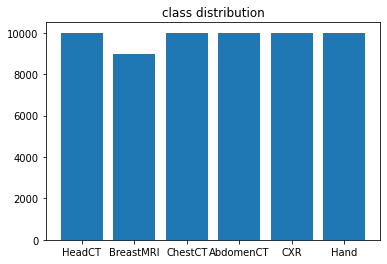

In [65]:
import matplotlib.pyplot as plt

plt.bar(classNames,numEach)
plt.title("class distribution")

Because it is comparable to the <a href="http://yann.lecun.com/exdb/mnist/">MNIST dataset</a>, which has 70,000 total 28 x 28 images of handwritten digits from 0 - 9, we call this the MedNIST dataset. Notice, however, that the data aren't perfectly balanced. We'll address that while training the model.

As the saying goes, a picture is worth 1,000 ± 32 statistics, so let's examine a few random sample images. The following cell can be run repeatedly.
   
### **Few examples of the dataset :::**

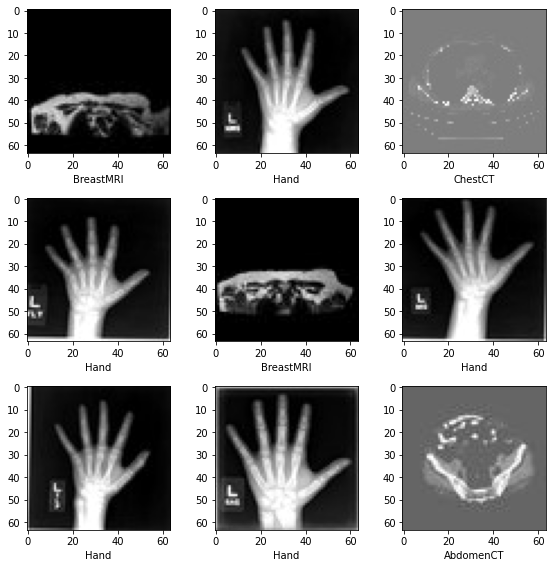

In [66]:
mp.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTotal, size=9)):  # Take a random sample of 9 images and
    im = Image.open(imageFilesList[k])                      #      plot and label them
    arr = np.array(im)
    mp.subplot(3,3,i+1)
    mp.xlabel(classNames[imageClass[k]])
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()


# **probable use of this dataset  :::**

In most of the cases nowadays the full body CT scan is being done and to check problem in different parts of the body ,the cropped images of the diffrent parts can be sent to the doctors.So to send them with an automated system we need to do perfect classification of them. We have implemented this network to perform it perfectly.

## Transforming Data and Partitioning into Training, Validation, and Testing Sets

Depending on the images shown, you may notice a few things. There are definitely higher and lower quality images. Also, some images also have a different scale - the background isn't black but gray. Because there's a smaller difference between pixels, our model might have a harder time extracting information from them. Thus, to increase the contrast, we first rescale every image so the pixel values run from 0 to 1. 

Next, we subtract the mean pixel value of each individual image from the rest. The network could in principle learn to do this through training. However, the activation functions tend to be most sensitive / nonlinear near zero. Therefore, shifting our data to have an average input value of zero will improve the sensitivity and stability of initial training steps and tends to speed things up a little. While it doesn't matter much for the simple model we use here, such tricks can make a noticeable difference in complex models.

Also, before doing any of these, we'll need to convert the JPEG images into tensors. We define a function below that combines all these steps.

In [67]:
toTensor = tv.transforms.ToTensor()
def scaleImage(x):          # Pass a PIL image, return a tensor
    y = toTensor(x)
    if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Subtract the mean value of the image
    return z


With the image-to-tensor transformation function defined, we now create a master tensor out of all these images. We also create a tensor for the labels. Execution of this code takes a moment. We double check the final range of scaled pixel values and verify that the mean is (practically) zero.


In [68]:
imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Load, scale, and stack image (X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))


Rescaled min pixel value = -0.786; Max = 0.972; Mean = -3.11e-09


With everything in order so far, we move on to partitioning these master tensors into three datatsets.

Because a model may have millions of free parameters, it is quite possible for it to <em>overfit</em> to the data provided. That is, it may adjust its weights to the precise values needed to predict every given image correctly, yet fail to recognize even slight variations on the original images, let alone brand new ones.

A common solution is to separate data into a training set, used to minimize the loss function, and a validation set, evaluated separately during training without directly affecting the model's weights. However, the validation set may be used to modify the <em>hyperparameters</em> (parameters outside the model governing its training), select the best model every epoch, or indirectly impact the training in some other way. For this reason, a third, independent testing set is usually created for final evaluation once the training is complete.

Because the more data the model sees, the more accurate it tends to become, we usually reserve relatively small fractions for validation and testing.

PyTorch has a built in <a href="https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html">Dataset</a> object that can simplify these steps when working with more complex types of data, but in this case, they would require more effort than they save.

The code below will randomly assign approximately 10% of the indices to lists corresponding to the validation and testing sets. Once this is done, we can create these datasets by slicing the master image and label tensors using these lists.


In [69]:
validFrac = 0.1   # Define the fraction of images to move to validation dataset
testFrac = 0.1    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Count the number in each set
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"Validation =",nValid,"Testing =",nTest)



Training images = 47381 Validation = 5833 Testing = 5740


If we're satisfied with the breakdown into training, validation, and testing, we can now use these lists to slice the master tensors with the code below. If not, we can rerun the cell above with different fractions set aside.


In [70]:
trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    #       training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]


## Model Architecture

The details of the architecture are explained in the comments within the code, but here we give an overview of the two types of layers encountered.

The first is the <em>convolutional</em> layer. When interpreting an image, the eye first identifies edges and boundaries. Then, one can make out curves, shapes, and more complex structures at higher levels of abstraction. By only combining information from nearby pixels at first, a series of convolutional layers mimics this organic process. The size of the convolution is how many adjacent pixels are weighted and added up when moving to the next layer, and we can apply multiple convolutions to every pixel in an image (or in a higher layer). Pictured below is a single 3 × 3 convolution. The value of each pixel of the convolutional kernel - these are the weights that are trained - is multiplied with the corresponding pixel value within the neighborhood of the original, central image pixel. These products are summed up, and the total is placed in the central pixel (node, to use the nomenclature) of the new layer. The process is repeated for each pixel and each convolution within the layer. Several convolutional layers can be stacked on top of each other; this has the effect of finding increasingly complex features.



After several convolutional layers, it is typical to have a few fully connected layers. First, all the information from the last layer is "flattened" into a vector. In a fully connected layer, there are weights connecting every single node (place to store a value) of the input layer to every single node of the output layer - no special preference is given to neighboring nodes as in the pixels of a convolutional layer. The weights multiply the values in the nodes of the input layer, are summed together, and then placed in a node of the output layer. This is repeated for each node in the output layer.

Now, there is one additional step in each of these that has been omitted: appication of the activation function. If the linear function `y = 3x + 2` is composed with `z = 4y - 7`, then z is still a linear function of x: `z = 12x + 1`. The same thing is true for linear functions in higher dimensions (multiplication by weights and summing, as we have been doing). Without the activation function, no matter how many layers we stack together, it could ultimately be replaced by a single one. To avoid this, at each output layer, we apply a nonlinear activation function. This need not be the same function at every layer. In this architecture, we choose <a href="http://image-net.org/challenges/posters/JKU_EN_RGB_Schwarz_poster.pdf">ELU</a> functions, but there are many other popular options, such as <a href="https://en.wikipedia.org/wiki/Rectifier_(neural_networks)">ReLU</a>.


In [71]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
        # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
        # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
        # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
        # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
        # of the image), and this makes the effective image dimension decreases.
        
        numConvs1 = 5
        convSize1 = 7
        numConvs2 = 10
        convSize2 = 7
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        
        fcSize1 = 400
        fcSize2 = 80
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = F.elu(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = F.elu(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = F.elu(self.ful1(x)) # Feed through first fully connected layer, apply activation
        x = F.elu(self.ful2(x)) # Feed through second FC layer, apply output
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

With the architecture defined, we create an instance of the model. This single line is separated out so that we can continue or repeat the training code below without resetting the model from scratch, if needed.

### Initialization of model 

In [72]:
model = MedNet(imageWidth,imageHeight,numClass).to(dev)

## Training the Model



## **training and results using SGD optimizer**

In [ ]:
learnRate = 0.001          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.SGD(model.parameters(), lr = learnRate)   # Initialize an optimizer

train_loss_list_sgd = []
valid_loss_list_sgd = []

conv1_grad=[]
conv2_grad=[]

for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            #opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats

    train_loss_list_sgd.append(epochLoss)
    valid_loss_list_sgd.append(validLoss)
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))

    conv1_grad.append(torch.linalg.norm(model.cnv1.weight.grad))
    conv2_grad.append(torch.linalg.norm(model.cnv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.cnv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.cnv2.weight.grad))
    print("\n")
    # if validLoss > t2vRatio * epochLoss:
    #     t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
    #     if t2vEpochs < 1:
    #         print("Validation loss too high; halting to prevent overfitting")
    #         break
    

Epoch =   0; Training loss = 1.7504; Validation loss = 1.6789
conv1 grads tensor(0.3697, device='cuda:0')
conv2 grads tensor(0.6123, device='cuda:0')


Epoch =   1; Training loss = 1.4850; Validation loss = 1.2159
conv1 grads tensor(0.8985, device='cuda:0')
conv2 grads tensor(1.1299, device='cuda:0')


Epoch =   2; Training loss = 0.9295; Validation loss = 0.6972
conv1 grads tensor(0.5759, device='cuda:0')
conv2 grads tensor(0.7440, device='cuda:0')


Epoch =   3; Training loss = 0.5643; Validation loss = 0.4657
conv1 grads tensor(0.3904, device='cuda:0')
conv2 grads tensor(0.4835, device='cuda:0')


Epoch =   4; Training loss = 0.3979; Validation loss = 0.3492
conv1 grads tensor(0.2668, device='cuda:0')
conv2 grads tensor(0.3501, device='cuda:0')


Epoch =   5; Training loss = 0.3126; Validation loss = 0.2894
conv1 grads tensor(0.1005, device='cuda:0')
conv2 grads tensor(0.2637, device='cuda:0')


Epoch =   6; Training loss = 0.2644; Validation loss = 0.2525
conv1 grads tensor(0.2455,

**Results visualization :::**

Text(0, 0.5, 'loss')

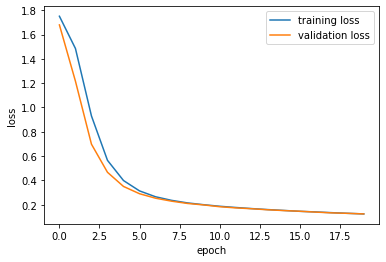

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list_sgd,label='training loss')
plt.plot(valid_loss_list_sgd,label='validation loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0.5, 0, 'epoch')

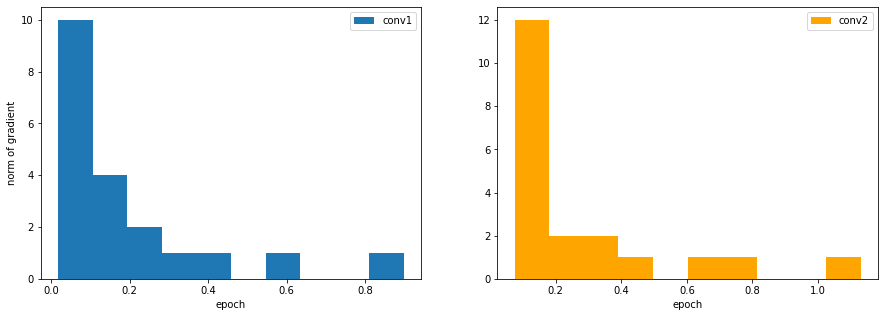

In [ ]:
# plt.plot(conv1_grad,label='first layer')
# plt.plot(conv2_grad,label='second layer')
# plt.legend()
cnv1 = []
cnv2 = []
for i in range(len(conv1_grad)):
  cnv1.append(conv1_grad[i].cpu())
  cnv2.append(conv2_grad[i].cpu())

plt.figure(figsize=(15,5))
plt.title("norm of the gradients")

plt.subplot(121)
plt.hist(cnv1,label='conv1')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("norm of gradient")

plt.subplot(122)
plt.hist(cnv2,label='conv2',color='orange')
plt.legend()
plt.xlabel("epoch")
#plt.ylabel("norm of gradient")

In [ ]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("Accuracy :",correct/nTest)
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)


Correct predictions:  5578 of 5830
Accuracy : 0.9567753001715266
Confusion Matrix:
[[911   1  42   6   6   0]
 [  5 996   4  11   1   3]
 [ 51   0 910  10   2   0]
 [ 62  11   6 905   0   2]
 [ 10   0   2   0 875   0]
 [  0  12   5   0   0 981]]
['ChestCT', 'Hand', 'AbdomenCT', 'HeadCT', 'BreastMRI', 'CXR']


So the training is fine, and at the end of 20th epoch the validation loss is almost similar to the training loss.And the norm of the gradients in the two convolution layers are shown above and as our expectation the histogram beans are heavy near zero and so we are happy with our performance. So now let's see if we can do it more faster with the momentum

## **Training with SGD momentum :::**

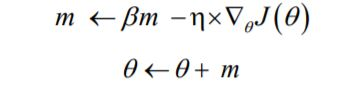

In [ ]:
learnRate = 0.001          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.SGD(model.parameters(), lr = learnRate, momentum = 0.9)   # Initialize an optimizer

train_loss_list_sgd_momentum = []
valid_loss_list_sgd_momentum = []

conv1_grad_sgd_momentum=[]
conv2_grad_sgd_momentum=[]

for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            #opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats

    train_loss_list_sgd_momentum.append(epochLoss)
    valid_loss_list_sgd_momentum.append(validLoss)
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))

    conv1_grad_sgd_momentum.append(torch.linalg.norm(model.cnv1.weight.grad))
    conv2_grad_sgd_momentum.append(torch.linalg.norm(model.cnv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.cnv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.cnv2.weight.grad))
    print("\n")
    # if validLoss > t2vRatio * epochLoss:
    #     t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
    #     if t2vEpochs < 1:
    #         print("Validation loss too high; halting to prevent overfitting")
    #         break
    

Epoch =   0; Training loss = 0.1048; Validation loss = 0.0908
conv1 grads tensor(0.0496, device='cuda:0')
conv2 grads tensor(0.1948, device='cuda:0')


Epoch =   1; Training loss = 0.0731; Validation loss = 0.0659
conv1 grads tensor(0.1330, device='cuda:0')
conv2 grads tensor(0.3193, device='cuda:0')


Epoch =   2; Training loss = 0.0522; Validation loss = 0.0468
conv1 grads tensor(0.0382, device='cuda:0')
conv2 grads tensor(0.1728, device='cuda:0')


Epoch =   3; Training loss = 0.0407; Validation loss = 0.0383
conv1 grads tensor(0.0578, device='cuda:0')
conv2 grads tensor(0.0880, device='cuda:0')


Epoch =   4; Training loss = 0.0323; Validation loss = 0.0327
conv1 grads tensor(0.0349, device='cuda:0')
conv2 grads tensor(0.0403, device='cuda:0')


Epoch =   5; Training loss = 0.0268; Validation loss = 0.0260
conv1 grads tensor(0.1059, device='cuda:0')
conv2 grads tensor(0.2735, device='cuda:0')


Epoch =   6; Training loss = 0.0222; Validation loss = 0.0253
conv1 grads tensor(0.0747,

Text(0, 0.5, 'loss')

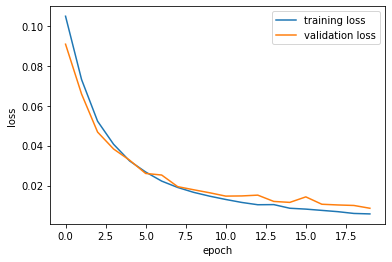

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list_sgd_momentum,label='training loss')
plt.plot(valid_loss_list_sgd_momentum,label='validation loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0.5, 0, 'epoch')

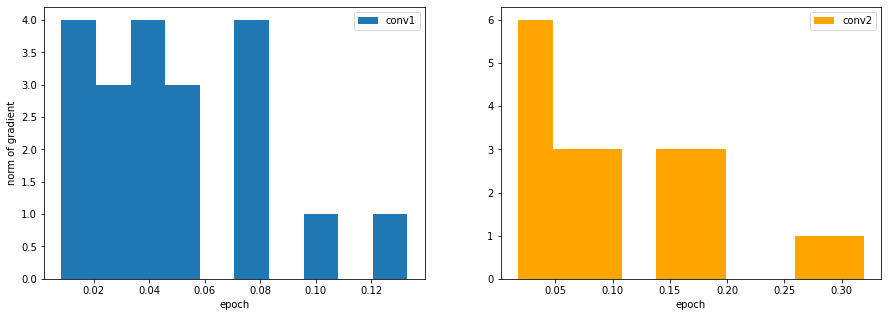

In [ ]:
# plt.plot(conv1_grad,label='first layer')
# plt.plot(conv2_grad,label='second layer')
# plt.legend()
cnv1 = []
cnv2 = []
for i in range(len(conv1_grad)):
  cnv1.append(conv1_grad_sgd_momentum[i].cpu())
  cnv2.append(conv2_grad_sgd_momentum[i].cpu())

plt.figure(figsize=(15,5))
plt.title("norm of the gradients")

plt.subplot(121)
plt.hist(cnv1,label='conv1')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("norm of gradient")

plt.subplot(122)
plt.hist(cnv2,label='conv2',color='orange')
plt.legend()
plt.xlabel("epoch")
#plt.ylabel("norm of gradient")

In [ ]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("Accuracy :",correct/nTest)
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)


Correct predictions:  5809 of 5830
Accuracy : 0.9963979416809605
Confusion Matrix:
[[ 965    0    1    0    0    0]
 [   0 1015    0    4    0    1]
 [   7    0  966    0    0    0]
 [   0    2    0  984    0    0]
 [   2    0    0    0  885    0]
 [   0    4    0    0    0  994]]
['ChestCT', 'Hand', 'AbdomenCT', 'HeadCT', 'BreastMRI', 'CXR']


let's compare the performance :

Text(0.5, 1.0, 'loss of sgd with momentum')

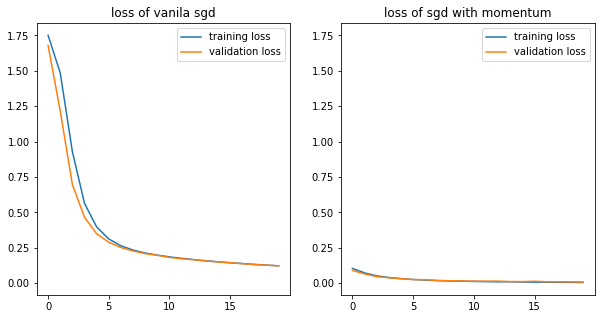

In [ ]:
# Plot the figure
fig = plt.figure(figsize=(10,5))

# Add the axes
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)

# Create data points
t = np.linspace(-5, 5, 100)

ax1.plot(train_loss_list_sgd,label='training loss')
ax1.plot(valid_loss_list_sgd,label='validation loss')
ax1.legend()
ax1.set_title("loss of vanila sgd")

ax2.plot(train_loss_list_sgd_momentum,label='training loss')
ax2.plot(valid_loss_list_sgd_momentum,label='validation loss')
ax2.legend()
ax2.set_title("loss of sgd with momentum")


So the improvement is very clear, from the very first step the training and validation loss is lower than the normal sgd . Though in this case the histogram bin of zero is less heavy than the previous vanila sgd, so may be it is stopping near the optima but giving a better performance( in case of faster convergence)  

So , lets take a look if we can do it more faster with adapted direction and step lengths or not.

## **Training using RMSprop :::**

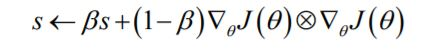

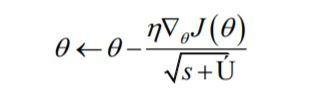

**learning rate = 0.001**

In [16]:
learnRate = 0.001          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.RMSprop(model.parameters(), lr = learnRate)   # Initialize an optimizer
train_loss_list_rmsprop = []
valid_loss_list_rmsprop = []

conv1_grad_rmsprop=[]
conv2_grad_rmsprop=[]

for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            #opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats

    train_loss_list_rmsprop.append(epochLoss)
    valid_loss_list_rmsprop.append(validLoss)
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))

    conv1_grad_rmsprop.append(torch.linalg.norm(model.cnv1.weight.grad))
    conv2_grad_rmsprop.append(torch.linalg.norm(model.cnv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.cnv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.cnv2.weight.grad))
    print("\n")
    # if validLoss > t2vRatio * epochLoss:
    #     t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
    #     if t2vEpochs < 1:
    #         print("Validation loss too high; halting to prevent overfitting")
    #         break
    

Epoch =   0; Training loss = 1.7972; Validation loss = 1.7963
conv1 grads tensor(0., device='cuda:0')
conv2 grads tensor(0., device='cuda:0')


Epoch =   1; Training loss = 1.7951; Validation loss = 1.7995
conv1 grads tensor(0., device='cuda:0')
conv2 grads tensor(0., device='cuda:0')


Epoch =   2; Training loss = 1.7946; Validation loss = 1.7952
conv1 grads tensor(0., device='cuda:0')
conv2 grads tensor(0., device='cuda:0')


Epoch =   3; Training loss = 1.7946; Validation loss = 1.7931
conv1 grads tensor(0., device='cuda:0')
conv2 grads tensor(0., device='cuda:0')


Epoch =   4; Training loss = 1.7948; Validation loss = 1.7963
conv1 grads tensor(0., device='cuda:0')
conv2 grads tensor(0., device='cuda:0')


Epoch =   5; Training loss = 1.7950; Validation loss = 1.7944
conv1 grads tensor(0., device='cuda:0')
conv2 grads tensor(0., device='cuda:0')


Epoch =   6; Training loss = 1.7945; Validation loss = 1.7975
conv1 grads tensor(0., device='cuda:0')
conv2 grads tensor(0., device='cud

**results :**

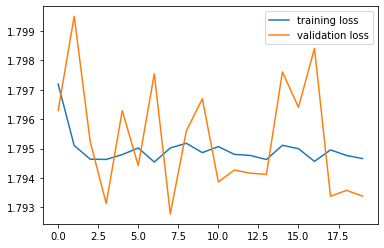

In [17]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list_rmsprop,label='training loss')
plt.plot(valid_loss_list_rmsprop,label='validation loss')
plt.legend()


Text(0.5, 0, 'epoch')

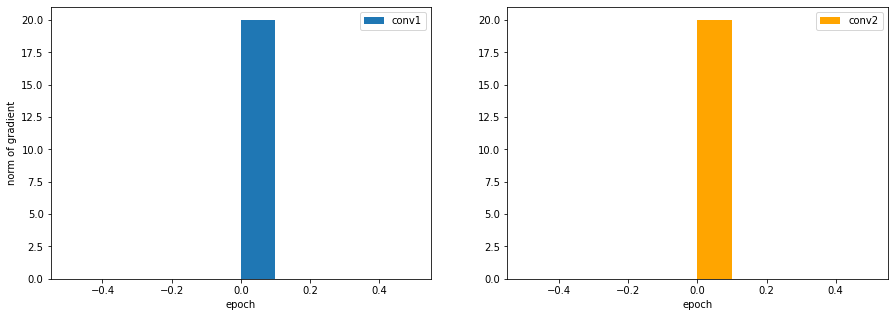

In [20]:
# plt.plot(conv1_grad,label='first layer')
# plt.plot(conv2_grad,label='second layer')
# plt.legend()
cnv1 = []
cnv2 = []
for i in range(len(conv1_grad_rmsprop)):
  cnv1.append(conv1_grad_rmsprop[i].cpu())
  cnv2.append(conv2_grad_rmsprop[i].cpu())

plt.figure(figsize=(15,5))
plt.title("norm of the gradients")

plt.subplot(121)
plt.hist(cnv1,label='conv1')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("norm of gradient")

plt.subplot(122)
plt.hist(cnv2,label='conv2',color='orange')
plt.legend()
plt.xlabel("epoch")
#plt.ylabel("norm of gradient")

In [21]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("accuracy :",correct/nTest)
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)


Correct predictions:  963 of 5740
accuracy : 0.16777003484320557
Confusion Matrix:
[[  0   0   0 972   0   0]
 [  0   0   0 898   0   0]
 [  0   0   0 992   0   0]
 [  0   0   0 963   0   0]
 [  0   0   0 939   0   0]
 [  0   0   0 976   0   0]]
['HeadCT', 'BreastMRI', 'ChestCT', 'AbdomenCT', 'CXR', 'Hand']


It is clear that with time the step length is decreasing here,and the surface have some saddle points. So if we start with very low step length initially then it is getting stucked somewhere in those saddle points(that is clear from the histogram of norm of the gradients of the two convolutional layer) and unable to get out from it. let's see if we start with a very higher initial step length what happens.

**learning rate = 0.01**

In [36]:
learnRate = 0.01          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.RMSprop(model.parameters(), lr = learnRate)   # Initialize an optimizer

train_loss_list_rmsprop_1 = []
valid_loss_list_rmsprop_1 = []

conv1_grad_rmsprop_1=[]
conv2_grad_rmsprop_1=[]

for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            #opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats

    train_loss_list_rmsprop_1.append(epochLoss)
    valid_loss_list_rmsprop_1.append(validLoss)
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))

    conv1_grad_rmsprop_1.append(torch.linalg.norm(model.cnv1.weight.grad))
    conv2_grad_rmsprop_1.append(torch.linalg.norm(model.cnv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.cnv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.cnv2.weight.grad))
    print("\n")
    # if validLoss > t2vRatio * epochLoss:
    #     t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
    #     if t2vEpochs < 1:
    #         print("Validation loss too high; halting to prevent overfitting")
    #         break
    

Epoch =   0; Training loss = 1669.2226; Validation loss = 4.5469
conv1 grads tensor(7.8533, device='cuda:0')
conv2 grads tensor(6.2478, device='cuda:0')


Epoch =   1; Training loss = 2.6672; Validation loss = 1.4225
conv1 grads tensor(5.4575, device='cuda:0')
conv2 grads tensor(3.7699, device='cuda:0')


Epoch =   2; Training loss = 21.2574; Validation loss = 1.5393
conv1 grads tensor(19.0217, device='cuda:0')
conv2 grads tensor(5.5866, device='cuda:0')


Epoch =   3; Training loss = 1.1805; Validation loss = 0.8996
conv1 grads tensor(1.6627, device='cuda:0')
conv2 grads tensor(0.8192, device='cuda:0')


Epoch =   4; Training loss = 0.8161; Validation loss = 0.7182
conv1 grads tensor(1.6505, device='cuda:0')
conv2 grads tensor(0.8761, device='cuda:0')


Epoch =   5; Training loss = 1.3059; Validation loss = 1.2407
conv1 grads tensor(0.6648, device='cuda:0')
conv2 grads tensor(0.2168, device='cuda:0')


Epoch =   6; Training loss = 1.4143; Validation loss = 1.4079
conv1 grads tensor(4.

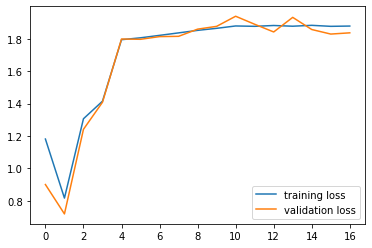

In [38]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list_rmsprop_1[3:],label='training loss')
plt.plot(valid_loss_list_rmsprop_1[3:],label='validation loss')
plt.legend()


Text(0.5, 0, 'epoch')

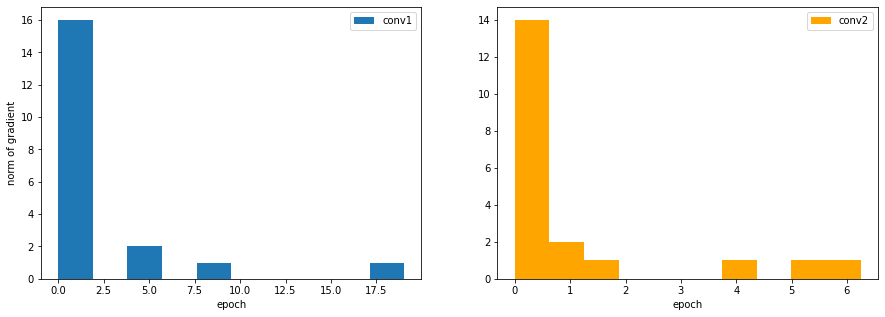

In [39]:
# plt.plot(conv1_grad,label='first layer')
# plt.plot(conv2_grad,label='second layer')
# plt.legend()
cnv1 = []
cnv2 = []
for i in range(len(conv1_grad_rmsprop_1)):
  cnv1.append(conv1_grad_rmsprop_1[i].cpu())
  cnv2.append(conv2_grad_rmsprop_1[i].cpu())

plt.figure(figsize=(15,5))
plt.title("norm of the gradients")

plt.subplot(121)
plt.hist(cnv1,label='conv1')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("norm of gradient")

plt.subplot(122)
plt.hist(cnv2,label='conv2',color='orange')
plt.legend()
plt.xlabel("epoch")
#plt.ylabel("norm of gradient")

In [27]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("accuracy :",correct/nTest)
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)


Correct predictions:  898 of 5740
accuracy : 0.1564459930313589
Confusion Matrix:
[[  0 972   0   0   0   0]
 [  0 898   0   0   0   0]
 [  0 992   0   0   0   0]
 [  0 963   0   0   0   0]
 [  0 939   0   0   0   0]
 [  0 976   0   0   0   0]]
['HeadCT', 'BreastMRI', 'ChestCT', 'AbdomenCT', 'CXR', 'Hand']


## **Training using Adagrad :::**

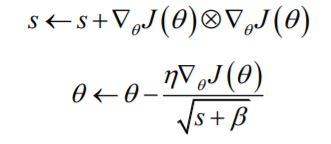

**learning rate = 0.001**

In [46]:
learnRate = 0.001          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.Adagrad(model.parameters(), lr = learnRate)   # Initialize an optimizer

train_loss_list_adagrad = []
valid_loss_list_adagrad = []

conv1_grad_adagrad=[]
conv2_grad_adagrad=[]

for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            #opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats

    train_loss_list_adagrad.append(epochLoss)
    valid_loss_list_adagrad.append(validLoss)
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))

    conv1_grad_adagrad.append(torch.linalg.norm(model.cnv1.weight.grad))
    conv2_grad_adagrad.append(torch.linalg.norm(model.cnv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.cnv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.cnv2.weight.grad))
    print("\n")
    # if validLoss > t2vRatio * epochLoss:
    #     t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
    #     if t2vEpochs < 1:
    #         print("Validation loss too high; halting to prevent overfitting")
    #         break
    

Epoch =   0; Training loss = 0.1782; Validation loss = 0.0736
conv1 grads tensor(0.4360, device='cuda:0')
conv2 grads tensor(0.4186, device='cuda:0')


Epoch =   1; Training loss = 0.0503; Validation loss = 0.0367
conv1 grads tensor(0.1011, device='cuda:0')
conv2 grads tensor(0.1271, device='cuda:0')


Epoch =   2; Training loss = 0.0286; Validation loss = 0.0255
conv1 grads tensor(0.0627, device='cuda:0')
conv2 grads tensor(0.1104, device='cuda:0')


Epoch =   3; Training loss = 0.0198; Validation loss = 0.0209
conv1 grads tensor(0.1385, device='cuda:0')
conv2 grads tensor(0.1632, device='cuda:0')


Epoch =   4; Training loss = 0.0145; Validation loss = 0.0175
conv1 grads tensor(0.1356, device='cuda:0')
conv2 grads tensor(0.2058, device='cuda:0')


Epoch =   5; Training loss = 0.0111; Validation loss = 0.0148
conv1 grads tensor(0.1755, device='cuda:0')
conv2 grads tensor(0.2071, device='cuda:0')


Epoch =   6; Training loss = 0.0091; Validation loss = 0.0155
conv1 grads tensor(0.3270,

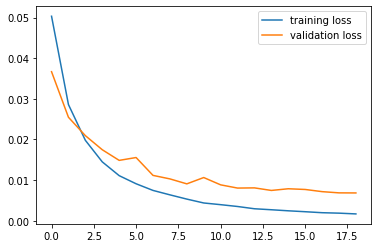

In [47]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list_adagrad[1:],label='training loss')
plt.plot(valid_loss_list_adagrad[1:],label='validation loss')
plt.legend()

Text(0.5, 0, 'epoch')

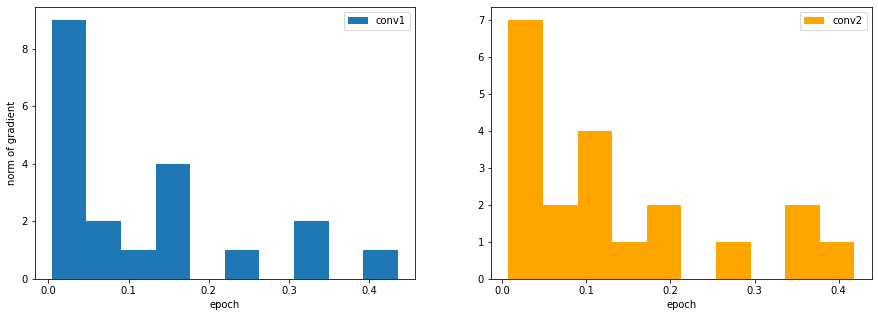

In [48]:
# plt.plot(conv1_grad,label='first layer')
# plt.plot(conv2_grad,label='second layer')
# plt.legend()
cnv1 = []
cnv2 = []
for i in range(len(conv1_grad_adagrad)):
  cnv1.append(conv1_grad_adagrad[i].cpu())
  cnv2.append(conv2_grad_adagrad[i].cpu())

plt.figure(figsize=(15,5))
plt.title("norm of the gradients")

plt.subplot(121)
plt.hist(cnv1,label='conv1')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("norm of gradient")

plt.subplot(122)
plt.hist(cnv2,label='conv2',color='orange')
plt.legend()
plt.xlabel("epoch")
#plt.ylabel("norm of gradient")

In [49]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("accuracy :",correct/nTest)
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)


Correct predictions:  5729 of 5740
accuracy : 0.9980836236933798
Confusion Matrix:
[[972   0   0   0   0   0]
 [  0 898   0   0   0   0]
 [  0   1 990   1   0   0]
 [  0   0   1 962   0   0]
 [  0   0   1   0 934   4]
 [  2   0   0   0   1 973]]
['HeadCT', 'BreastMRI', 'ChestCT', 'AbdomenCT', 'CXR', 'Hand']


## **training and results using Adam optimizer :::**

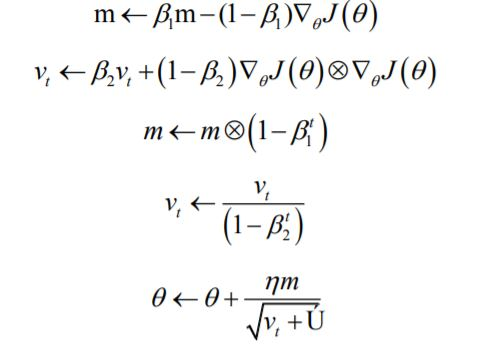

**learning rate = 0.01**

In [73]:
learnRate = 0.01          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.Adam(model.parameters(), lr = learnRate)   # Initialize an optimizer

train_loss_list_adam = []
valid_loss_list_adam = []

conv1_grad_adam=[]
conv2_grad_adam=[]

for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            #opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats

    train_loss_list_adam.append(epochLoss)
    valid_loss_list_adam.append(validLoss)
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))

    conv1_grad_adam.append(torch.linalg.norm(model.cnv1.weight.grad))
    conv2_grad_adam.append(torch.linalg.norm(model.cnv2.weight.grad))
    print("conv1 grads",torch.linalg.norm(model.cnv1.weight.grad)) 
    print("conv2 grads",torch.linalg.norm(model.cnv2.weight.grad))
    print("\n")
    # if validLoss > t2vRatio * epochLoss:
    #     t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
    #     if t2vEpochs < 1:
    #         print("Validation loss too high; halting to prevent overfitting")
    #         break
    

Epoch =   0; Training loss = 0.7477; Validation loss = 0.0571
conv1 grads tensor(0.9805, device='cuda:0')
conv2 grads tensor(0.4651, device='cuda:0')


Epoch =   1; Training loss = 0.0448; Validation loss = 0.0488
conv1 grads tensor(1.4743, device='cuda:0')
conv2 grads tensor(0.4238, device='cuda:0')


Epoch =   2; Training loss = 0.0258; Validation loss = 0.0181
conv1 grads tensor(0.0176, device='cuda:0')
conv2 grads tensor(0.0088, device='cuda:0')


Epoch =   3; Training loss = 0.0154; Validation loss = 0.0083
conv1 grads tensor(0.4857, device='cuda:0')
conv2 grads tensor(0.2536, device='cuda:0')


Epoch =   4; Training loss = 0.0140; Validation loss = 0.0346
conv1 grads tensor(0.3325, device='cuda:0')
conv2 grads tensor(0.1106, device='cuda:0')


Epoch =   5; Training loss = 0.0124; Validation loss = 0.0161
conv1 grads tensor(0.1015, device='cuda:0')
conv2 grads tensor(0.0444, device='cuda:0')


Epoch =   6; Training loss = 0.0202; Validation loss = 0.0325
conv1 grads tensor(0.1650,

**results :::**

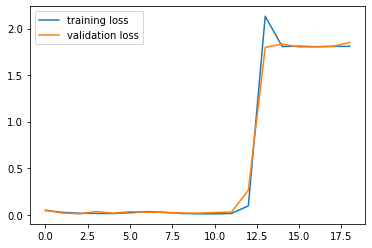

In [74]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list_adam[1:],label='training loss')
plt.plot(valid_loss_list_adam[1:],label='validation loss')
plt.legend()

Text(0.5, 0, 'epoch')

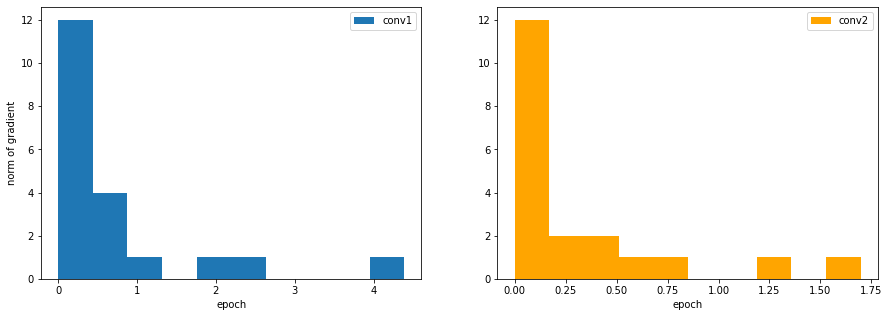

In [53]:
# plt.plot(conv1_grad,label='first layer')
# plt.plot(conv2_grad,label='second layer')
# plt.legend()
cnv1 = []
cnv2 = []
for i in range(len(conv1_grad_adam)):
  cnv1.append(conv1_grad_adam[i].cpu())
  cnv2.append(conv2_grad_adam[i].cpu())

plt.figure(figsize=(15,5))
plt.title("norm of the gradients")

plt.subplot(121)
plt.hist(cnv1,label='conv1')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("norm of gradient")

plt.subplot(122)
plt.hist(cnv2,label='conv2',color='orange')
plt.legend()
plt.xlabel("epoch")
#plt.ylabel("norm of gradient")

In [75]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("accuracy :",correct/nTest)
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)


Correct predictions:  898 of 5740
accuracy : 0.1564459930313589
Confusion Matrix:
[[  0 972   0   0   0   0]
 [  0 898   0   0   0   0]
 [  0 992   0   0   0   0]
 [  0 963   0   0   0   0]
 [  0 939   0   0   0   0]
 [  0 976   0   0   0   0]]
['HeadCT', 'BreastMRI', 'ChestCT', 'AbdomenCT', 'CXR', 'Hand']


Text(0.5, 1.0, 'loss of Adam')

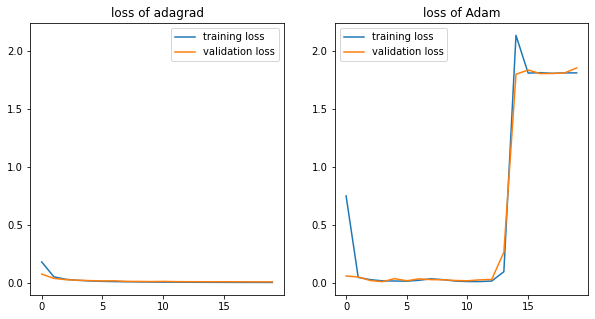

In [76]:
# Plot the figure
fig = plt.figure(figsize=(10,5))

# Add the axes
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)

# Create data points
t = np.linspace(-5, 5, 100)

ax1.plot(train_loss_list_adagrad,label='training loss')
ax1.plot(valid_loss_list_adagrad,label='validation loss')
ax1.legend()
ax1.set_title("loss of adagrad")

ax2.plot(train_loss_list_adam,label='training loss')
ax2.plot(valid_loss_list_adam,label='validation loss')
ax2.legend()
ax2.set_title("loss of Adam")


## **Predictions :::**

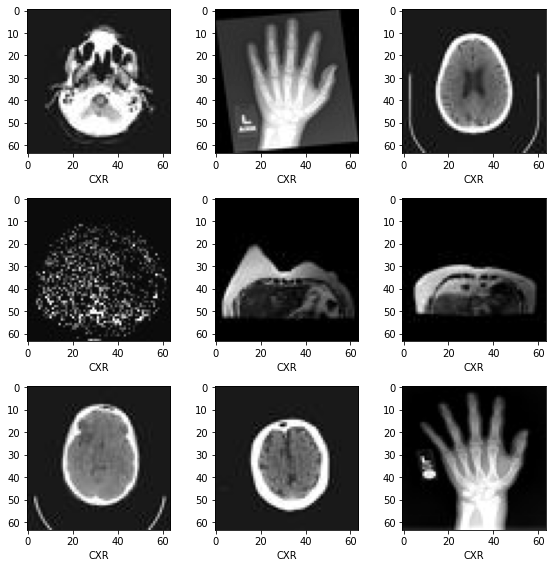

In [ ]:
def scaleBack(x):               # Pass a tensor, return a numpy array from 0 to 1
    if(x.min() < x.max()):      # Assuming the image isn't empty, rescale so its values run from 0 to 1
        x = (x - x.min())/(x.max() - x.min())
    return x[0].to(cpu).numpy() # Remove channel (grayscale anyway)

model.eval()
mp.subplots(3,3,figsize=(8,8))
imagesLeft = 9
permute = torch.randperm(nTest)        # Shuffle test data
testX = testX[permute,:,:,:]
testY = testY[permute]
for j in range(testBats):              # Iterate over test batches
    batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
    batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
    yOut = model(batX)                 # Pass test batch through model
    pred = yOut.max(1)[1].tolist()     # Generate predictions by finding the max Y values
    for i, y in enumerate(batY.tolist()):
        if imagesLeft and y != pred[i]:         # Compare the actual y value to the prediction
            imagesLeft -= 1
            mp.subplot(3,3,9-imagesLeft)
            mp.xlabel(classNames[pred[i]])      # Label image with what the model thinks it is
            mp.imshow(scaleBack(batX[i]),cmap='gray',vmin=0,vmax=1)
mp.tight_layout()
mp.show()
    
    

In [ ]:
pwd

'/dli/tasks/l-hx-07/task'

In [ ]:
ls

MedNIST.ipynb  hints.txt  images/  model/  resized/


In [ ]:
torch.save(model, 'saved_model')